# Homework #3 -- *you'll need to do this on google colab*

Student: Ante Malenica

0. Find data set on [kaggle](https://www.kaggle.com).
1. Provide posterior inference for a column of data with a `PyMC` ***normal-gamma specification***.
2. Find a different column of data for which a ***normal-gamma specification*** isn't justified.
3. Create a different `PyMC` specification that IS appropriate for this new data column:
    - here are your `PyMC` choices for [continuous distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/continuous.html)
    - here are your `PyMC` choices for [discrete distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/discrete.html)

### ...just make sure you've chosen a reasonable likelihood for your non-normal data and that the support of your priors makes sense for the values the parameters of your likelihood can take on...

4. Provide posterior inference for the parameters of your new specification given the column of non-normal data
using `PyMC` and provide an analysis of the MCMC chains.

## Question 0

The chosen dataset is from [Kaggle](https://www.kaggle.com/datasets/adityakadiwal/water-potability), available also on the GitHub account associated to the submission of this homework.

Below, the dataset is populated into Google Colab and is stored locally in the submission folder for this homework under them.

In [166]:
# Imports
import io
import random
import arviz as az
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import stats
from sklearn.mixture import GaussianMixture

In [118]:
# Dataset selection
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['water_potability.csv']))

Saving water_potability.csv to water_potability.csv


In [119]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


## Question 1

The selected column of the dataset named `Organic_carbon` which measures the "Amount of organic carbon in parts per million", will be used to find the posterior inference for its data with a PyMC normal-gamma specification. Visually, the distribution is as follows.

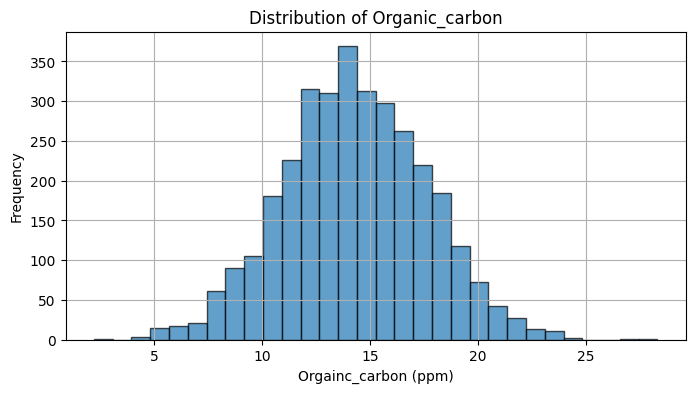

In [163]:
organic_carbon_column = df["Organic_carbon"]

# Plotting data
plt.figure(figsize=(8, 4))
plt.hist(organic_carbon_column, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of Organic_carbon')
plt.xlabel('Orgainc_carbon (ppm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

To determine the distribution for the `Organic_carbon` data column, the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) for normality will be used to determine if the data is indeed normally distributed. Here, a p-value of $p=0.05$ is used as a threshold to classify if the selected column of data is normally distributed.

In [164]:
statistic, p_value = stats.shapiro(organic_carbon_column)
print(f'Statistics={statistic}, p-value={p_value}')

if p_value > 0.05:
    print('Conclusion: Normally distributed')
else:
    print('Conclusion: Not normally distributed')

Statistics=0.9995209574699402, p-value=0.6202165484428406
Conclusion: Seems normally distributed


Given that the Shapiro-Wilk test concludes with $p=0.05$ that the data of `Organic_carbon` is assumed to be normally distributed, the posterior inference for its data with a PyMC normal-gamma specification can be found as follows.

In [180]:
# Initialize Prior Hyperparameters: specify prior distributions
theta_0,tau = 0,1; alpha,beta = 2,1/2
x = stats.norm().rvs(10)
normal_gamma_toy_model = pm.Model()

random.seed(1)
with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=x)

    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

HMC Split-Rhats {'theta': 1.0025, 'phi': 1.0024} | MH Split-Rhats {'theta': 1.0031, 'phi': 1.0243}


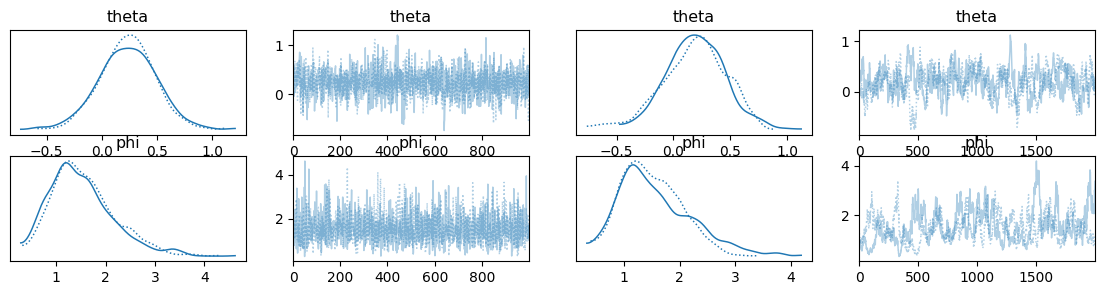

In [179]:
fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')
print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

In [174]:
# MCMC Effective Sample Size
idata_HMC.posterior['phi'].values.flatten().shape[-1]
az.summary(idata_HMC, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.03,0.32,-0.63,0.59,0.01,0.01,1491.95,1188.11,1.0
phi,0.98,0.41,0.28,1.72,0.01,0.01,1536.88,1262.59,1.0


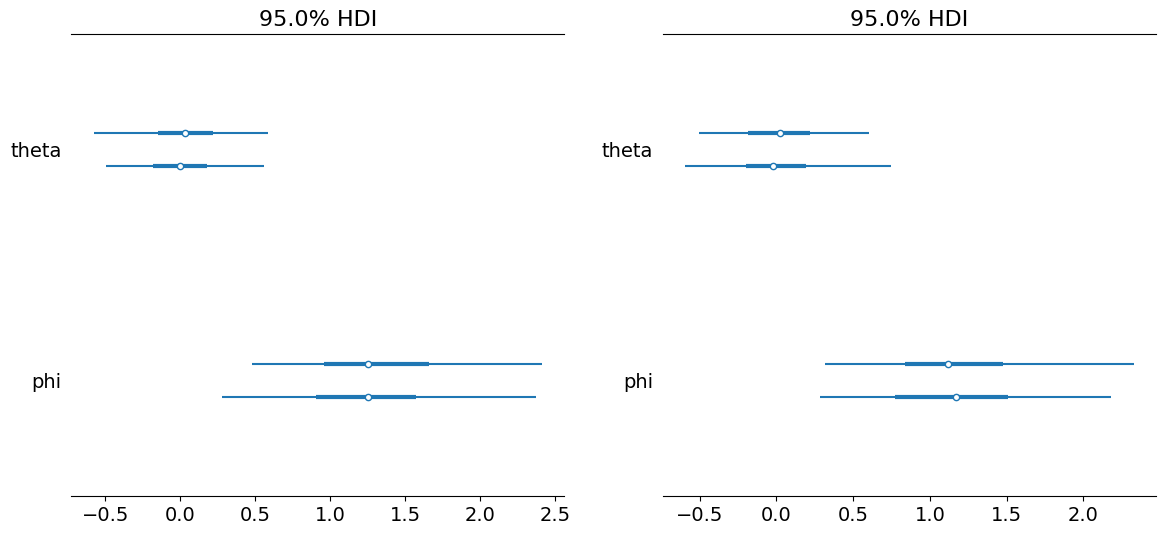

In [183]:
# MCMC Credible Intervals
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False,
               hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta","phi"], combined=False,
               hdi_prob=0.95, ax=ax[1]);

## Question 2

For a column of data for which a normal-gamma specification isn't justified, the `Conductivity` column of data representing "Electrical conductivity of water in μS/cm" will be used.

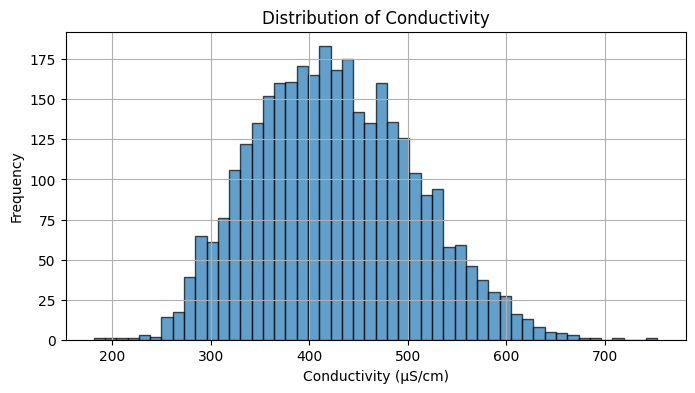

Statistics=0.9929697513580322, p-value=1.5015037824195332e-11
Conclusion: Does not seem normally distributed


In [125]:
conductivity_column = df["Conductivity"]

# Plotting data
plt.figure(figsize=(8, 4))
plt.hist(conductivity_column, bins=50, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of Conductivity')
plt.xlabel('Conductivity (μS/cm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

statistic, p_value = stats.shapiro(conductivity_column)
print(f'Statistics={statistic}, p-value={p_value}')

if p_value > 0.05:
    print('Conclusion: Seems normally distributed')
else:
    print('Conclusion: Does not seem normally distributed')

Given the conclusion from the Shapiro-Wilk test, the conductivity data is not normally distributed. Visually, the graph appears to have two peaks with a trough separating these peaks. Hence, this data may be better labelled as a bimodal distribution.

## Question 3

Recall that bimodal distributions, according to [Wikipedia (Multimodal Distributions)](https://en.wikipedia.org/wiki/Multimodal_distribution#Mixture_of_two_normal_distributions), is

> "A mixture of two normal distributions with equal standard deviations is bimodal only if their means differ by at least twice the common standard deviation".

Since the data of the `Condutivity` column is continuous, and it is believed that the data is a bimodal distribution, from the options in the [PyMC (mixture distribution) documentation](https://www.pymc.io/projects/docs/en/stable/api/distributions/mixture.html), calling `pymc.Mixture(...)` is appropriate.

In [182]:
# ChatGPT-4 assisted

data_2d = conductivity_column.values.reshape(-1, 1)

gmm = GaussianMixture(n_components=2)
gmm.fit(data_2d)

# Estimated parameters for the two components
mu1, mu2 = gmm.means_
sigma1, sigma2 = np.sqrt(gmm.covariances_)

print(f"Component 1: mu = {mu1}, sigma = {sigma1}")
print(f"Component 2: mu = {mu2}, sigma = {sigma2}")

Component 1: mu = [487.71834687], sigma = [[62.15432558]]
Component 2: mu = [373.67351946], sigma = [[53.08000045]]


In [181]:
# ChatGPT-4 assisted

with pm.Model() as model:
    # Define the mixture components (distributions)
    component1 = pm.Normal.dist(mu=mu1[0], sigma=sigma1[0][0])
    component2 = pm.Normal.dist(mu=mu2[0], sigma=sigma2[0][0])

    # Mixing proportion (the probability of being in component1)
    # Non-informative prior
    w = pm.Dirichlet('w', a=np.array([1, 1]))

    # Mixture distribution
    obs = pm.Mixture('obs', w=w, comp_dists=[component1, component2],
                     observed=conductivity_column)

## Question 4

Continuing from the code presented under Question 3 (where we also add a HalfNormal to enforce that $\sigma > 0$ for each model of the mixture):

In [190]:
# ChatGPT-4 assisted
mu1, mu2 = gmm.means_.flatten()
sigma1, sigma2 = np.sqrt(gmm.covariances_).flatten()
with pm.Model() as bimodal_model:
    # Priors for the component means and standard deviations
    mu1 = pm.Normal("mu1", mu=mu1, sigma=1)
    mu2 = pm.Normal("mu2", mu=mu2, sigma=1)
    sigma1 = pm.HalfNormal("sigma1", sigma=sigma1)
    sigma2 = pm.HalfNormal("sigma2", sigma=sigma2)

    # Mixing proportion
    w = pm.Dirichlet('w', a=np.array([1., 1.]))

    # Mixture components
    component1 = pm.Normal.dist(mu=mu1, sigma=sigma1)
    component2 = pm.Normal.dist(mu=mu2, sigma=sigma2)

    # Likelihood
    obs = pm.Mixture('obs', w=w, comp_dists=[component1, component2],
                     observed=conductivity_column)

    # Sample from the posterior using the default NUTS sampler
    MH = pm.Metropolis(vars=[mu1, mu2, sigma1, sigma2, w], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH)

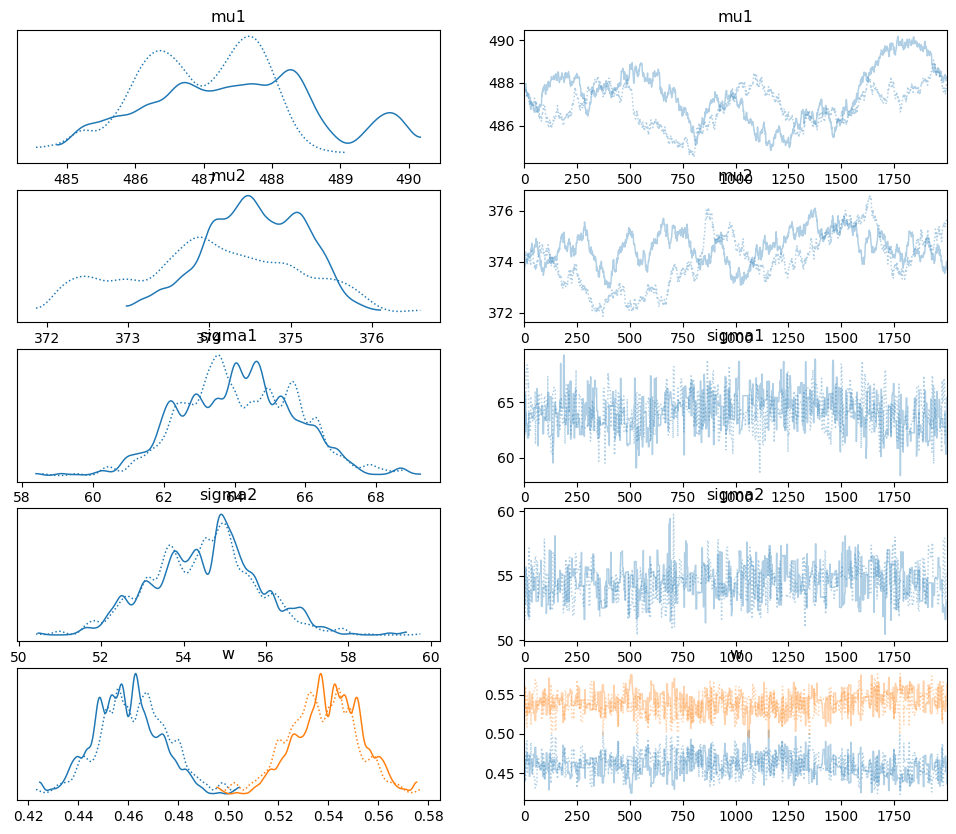

MH Split-Rhats {'coords': {'w_dim_0': {'dims': ('w_dim_0',), 'attrs': {}, 'data': [0, 1]}}, 'attrs': {}, 'dims': {'w_dim_0': 2}, 'data_vars': {'mu1': {'dims': (), 'attrs': {}, 'data': 1.1307729901113013}, 'mu2': {'dims': (), 'attrs': {}, 'data': 1.1995954646320446}, 'sigma1': {'dims': (), 'attrs': {}, 'data': 1.0029773975687082}, 'sigma2': {'dims': (), 'attrs': {}, 'data': 1.013042293896435}, 'w': {'dims': ('w_dim_0',), 'attrs': {}, 'data': [1.0240302374414123, 1.0240302374414123]}}}


In [192]:
az.plot_trace(idata_MH)
plt.show()
print("MH Split-Rhats", az.rhat(idata_MH).to_dict())

In [199]:
# MCMC Effective Sample Size for each parameter
ess_bimodal = az.ess(idata_MH)
az.summary(idata_MH, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,487.20,1.13,485.08,489.53,0.31,0.22,13.96,12.34,1.13
mu2,374.31,0.89,372.42,375.82,0.32,0.24,9.28,29.61,1.20
sigma1,64.15,1.61,61.13,66.92,0.15,0.10,123.81,714.11,1.00
sigma2,54.51,1.27,52.16,56.81,0.08,0.06,245.17,726.95,1.01
w[0],0.46,0.01,0.44,0.49,0.00,0.00,79.41,641.79,1.02
w[1],0.54,0.01,0.51,0.56,0.00,0.00,79.41,642.61,1.02


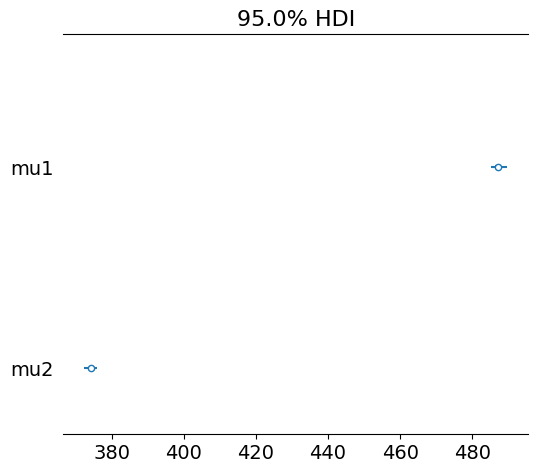

In [207]:
# Credible Intervals (mu)
az.plot_forest(idata_MH, var_names=["mu1", "mu2"], combined=True, hdi_prob=0.95)
plt.show()

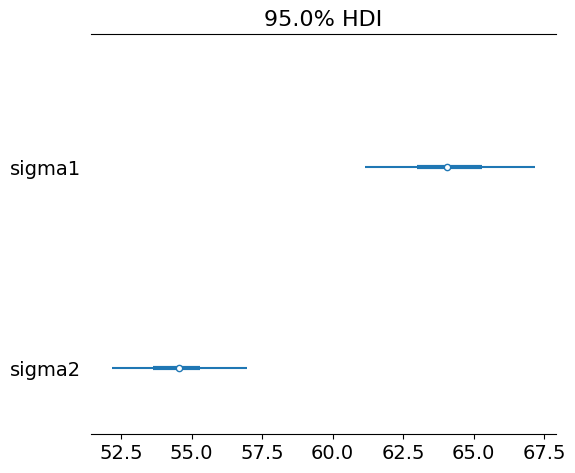

In [208]:
# Credible confidence interval (sigma)
az.plot_forest(idata_MH, var_names=["sigma1", "sigma2"], combined=True, hdi_prob=0.95)
plt.show()

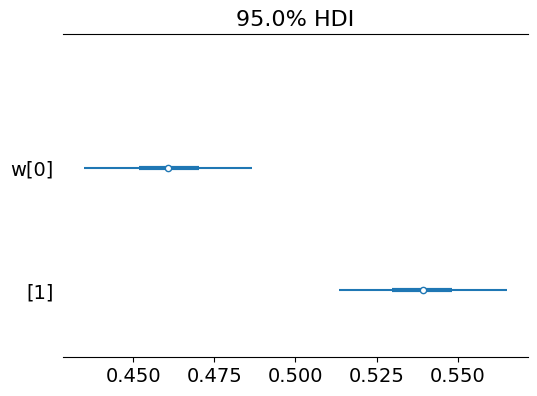

In [209]:
# Credible confidence interval (weights)
az.plot_forest(idata_MH, var_names=["w"], combined=True, hdi_prob=0.95)
plt.show()